C:\Users\varun\AppData\Local\Temp\ipykernel_12816\1493008719.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end, progress=False)


DEBUG: columns ->
 MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'MSFT'),
            (  'High', 'AAPL'),
            (  'High', 'MSFT'),
            (   'Low', 'AAPL'),
            (   'Low', 'MSFT'),
            (  'Open', 'AAPL'),
            (  'Open', 'MSFT'),
            ('Volume', 'AAPL'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

Head:
Ticker           AAPL       MSFT
Date                            
2018-01-02  40.380997  79.198349
2018-01-03  40.373962  79.566910
2018-01-04  40.561501  80.267220
2018-01-05  41.023296  81.262383
2018-01-08  40.870926  81.345291


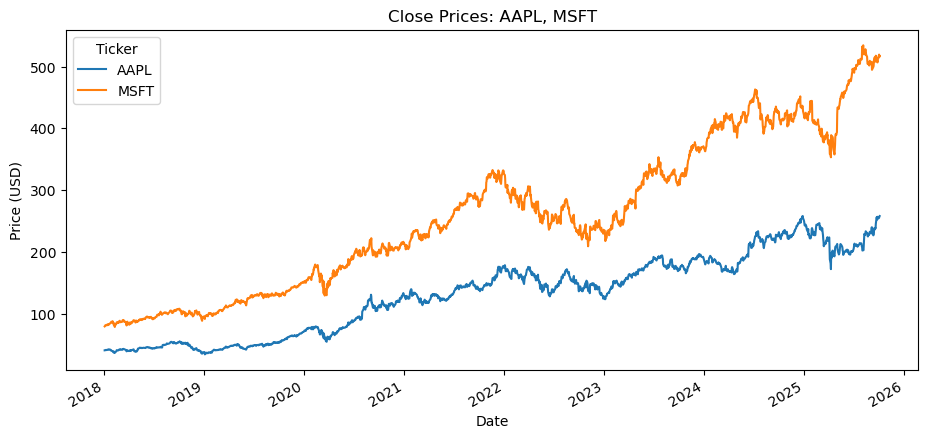

✅ Saved pair_prices.csv successfully


In [2]:

import datetime as dt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ["AAPL", "MSFT"]
start = "2018-01-01"
end = dt.date.today().isoformat()

raw = yf.download(tickers, start=start, end=end, progress=False)
print("DEBUG: columns ->\n", raw.columns)
 

if isinstance(raw.columns, pd.MultiIndex):
    prices = raw['Close'].copy()
else:
    
    prices = raw[[c for c in raw.columns if 'Close' in c]]

prices = prices[tickers]
prices = prices.dropna(how='all').ffill().bfill()

print("\nHead:")
print(prices.head())


prices.plot(figsize=(11,5), title=f"Close Prices: {', '.join(tickers)}")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

prices.to_csv("pair_prices.csv")
print("✅ Saved pair_prices.csv successfully")


Estimated hedge ratio (beta): 0.5059


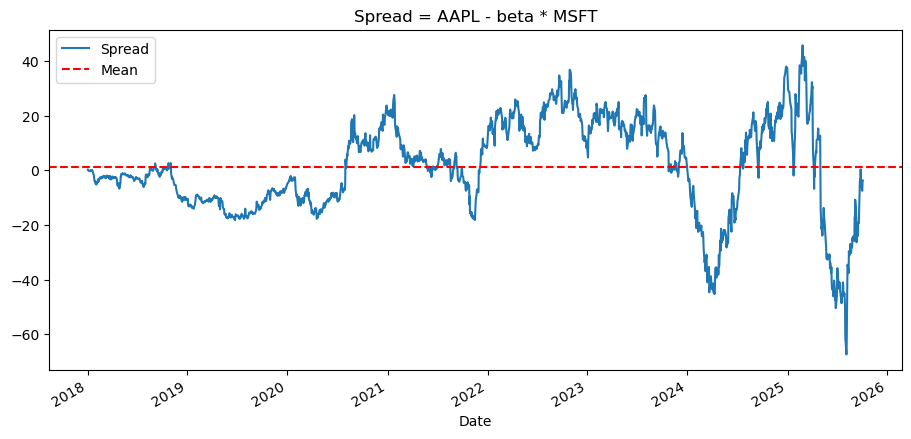

In [3]:
#Estimate beta (hedge ratio) and compute spread

import statsmodels.api as sm

y = prices["AAPL"]   # dependent
x = prices["MSFT"]   # independent


x_const = sm.add_constant(x)

model = sm.OLS(y, x_const).fit()
beta = model.params["MSFT"]

print(f"Estimated hedge ratio (beta): {beta:.4f}")


spread = y - beta * x
spread.name = "Spread"

spread.plot(figsize=(11,5), title="Spread = AAPL - beta * MSFT")
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()


Spread mean: 1.3105, Spread std: 17.1968


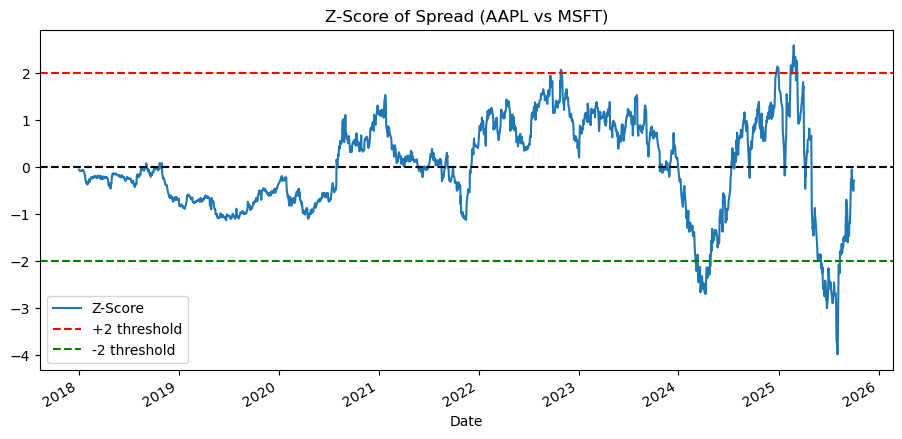

In [ ]:
# Computing Z-score of the spread

spread_mean = spread.mean()
spread_std = spread.std()

print(f"Spread mean: {spread_mean:.4f}, Spread std: {spread_std:.4f}")

# Z-score = (spread - mean) / std

zscore = (spread - spread_mean) / spread_std
zscore.name = "Z-Score"


plt.figure(figsize=(11,5))
zscore.plot(title="Z-Score of Spread (AAPL vs MSFT)")
plt.axhline(0, color='black', linestyle='--')
plt.axhline(2, color='red', linestyle='--', label='+2 threshold')
plt.axhline(-2, color='green', linestyle='--', label='-2 threshold')
plt.legend()
plt.show()


C:\Users\varun\AppData\Local\Temp\ipykernel_12816\3790733365.py:11: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  signals = signals.replace(to_replace=0, method='ffill')


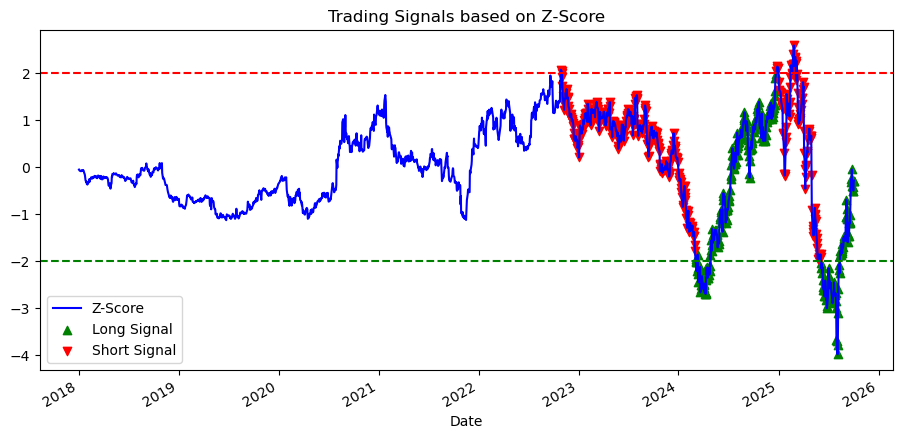

In [ ]:
# trading signals based on Z-score thresholds

signals = pd.Series(0, index=zscore.index, name="Signal")

# Trading rules

signals[zscore > 2] = -1   # spread high -> short spread
signals[zscore < -2] = 1   # spread low -> long spread
signals[(zscore > -1) & (zscore < 1)] = 0   # close positions


signals = signals.replace(to_replace=0, method='ffill')


plt.figure(figsize=(11,5))
zscore.plot(label="Z-Score", color="blue")
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.scatter(zscore.index, zscore.where(signals==1), marker="^", color="green", label="Long Signal")
plt.scatter(zscore.index, zscore.where(signals==-1), marker="v", color="red", label="Short Signal")
plt.title("Trading Signals based on Z-Score")
plt.legend()
plt.show()


Strategy Sharpe ratio: 0.91
Total return: 149.43%


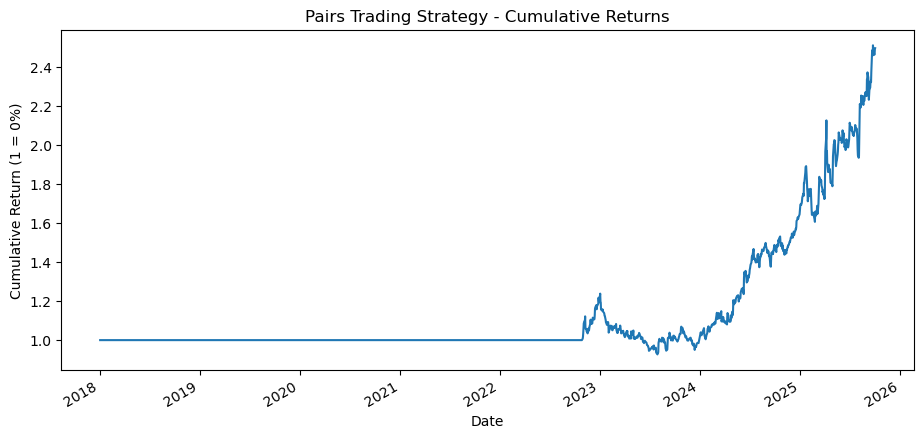

In [ ]:
# Backtest performance of strategy

import numpy as np

returns = prices.pct_change().dropna()
ret_aapl = returns["AAPL"]
ret_msft = returns["MSFT"]


strategy_ret = (ret_aapl - beta * ret_msft) * signals.shift(1)   # shift to avoid lookahead bias

cum_ret = (1 + strategy_ret).cumprod()


sharpe = np.sqrt(252) * strategy_ret.mean() / strategy_ret.std()

print(f"Strategy Sharpe ratio: {sharpe:.2f}")
print(f"Total return: {cum_ret.iloc[-1]-1:.2%}")


plt.figure(figsize=(11,5))
cum_ret.plot(title="Pairs Trading Strategy - Cumulative Returns")
plt.ylabel("Cumulative Return (1 = 0%)")
plt.show()


In [ ]:
#KNN Machine Learning Enhancement
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.DataFrame(index=spread.index)
df['spread'] = spread
df['zscore'] = zscore


# 1. Feature Engineering

df['zscore_lag1'] = df['zscore'].shift(1)
df['zscore_lag2'] = df['zscore'].shift(2)
df['spread_return'] = df['spread'].pct_change()
df['ma_zscore'] = df['zscore'].rolling(5).mean()
df = df.dropna()


# 2. Label Creation

look_ahead = 5
df['future_return'] = df['spread'].shift(-look_ahead) - df['spread']
df['label'] = np.where(df['future_return'] > 0, 1, 0)


# 3. Train-Test Split

features = ['zscore', 'zscore_lag1', 'zscore_lag2', 'spread_return', 'ma_zscore']
X = df[features]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


# 4. Train KNN

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


# 5. Prediction & Evaluation

df['knn_pred'] = np.nan
df.loc[X_test.index, 'knn_pred'] = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, df.loc[X_test.index, 'knn_pred']))
print(classification_report(y_test, df.loc[X_test.index, 'knn_pred']))


# 6. Combine with Z-Score Rule

upper_thresh = 2
lower_thresh = -2

df['final_signal'] = 0
df.loc[(df['zscore'] > upper_thresh) & (df['knn_pred'] == 1), 'final_signal'] = -1  # short spread
df.loc[(df['zscore'] < lower_thresh) & (df['knn_pred'] == 1), 'final_signal'] = 1   # long spread


KNN Accuracy: 0.5136986301369864
              precision    recall  f1-score   support

           0       0.52      0.41      0.46       291
           1       0.51      0.61      0.56       293

    accuracy                           0.51       584
   macro avg       0.51      0.51      0.51       584
weighted avg       0.51      0.51      0.51       584



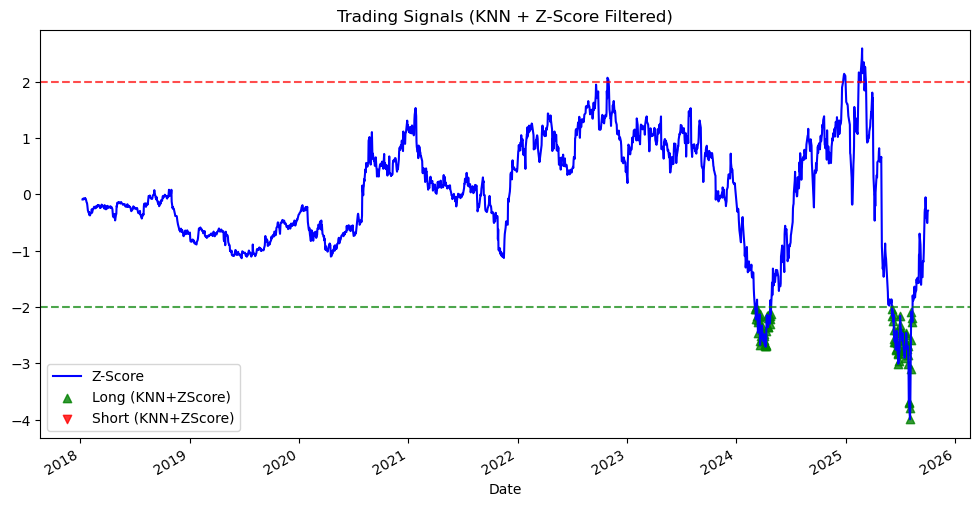

In [ ]:
# Visualization of Final Signal

plt.figure(figsize=(12,6))


df['zscore'].plot(label="Z-Score", color="blue")

plt.axhline(2, color='red', linestyle='--', alpha=0.7)
plt.axhline(-2, color='green', linestyle='--', alpha=0.7)


plt.scatter(df.index, df['zscore'].where(df['final_signal'] == 1),
            marker="^", color="green", label="Long (KNN+ZScore)", alpha=0.8)
plt.scatter(df.index, df['zscore'].where(df['final_signal'] == -1),
            marker="v", color="red", label="Short (KNN+ZScore)", alpha=0.8)

plt.title("Trading Signals (KNN + Z-Score Filtered)")
plt.legend()
plt.show()


Baseline Strategy:
  Sharpe Ratio: 0.14
  Win Rate: 19.5%

KNN + Z-Score Strategy:
  Sharpe Ratio: -0.14
  Win Rate: 2.1%


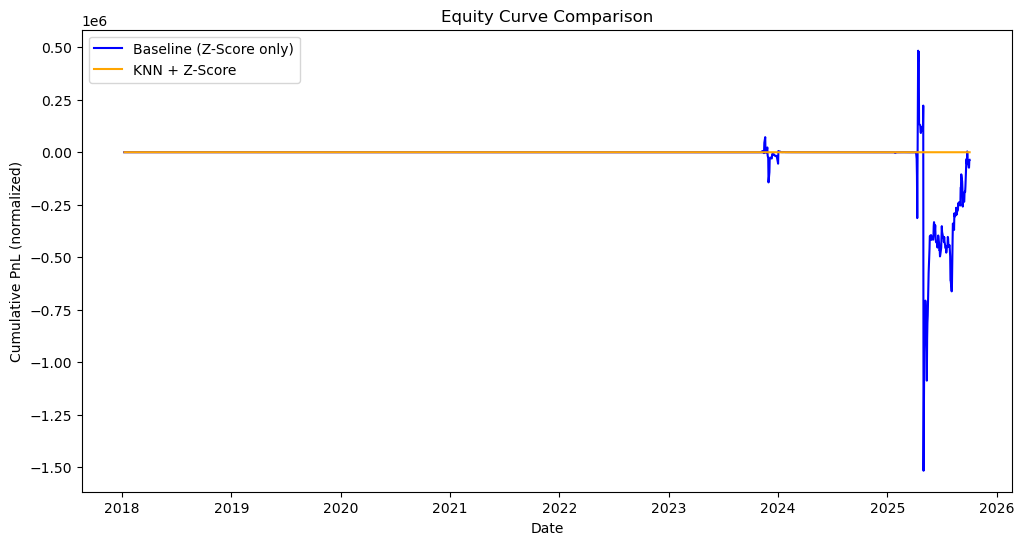

In [ ]:
# Backtest Performance 



def compute_strategy_pnl(signals, spread):
    """Compute PnL from trading signals and spread changes."""
    spread_ret = spread.pct_change().fillna(0)
    strategy_ret = signals.shift(1) * spread_ret  # lag signals to avoid look-ahead bias
    cum_pnl = (1 + strategy_ret).cumprod()
    return strategy_ret, cum_pnl

def sharpe_ratio(returns, freq=252):
    """Annualized Sharpe ratio."""
    return np.sqrt(freq) * returns.mean() / returns.std()

def win_rate(returns):
    """Proportion of positive returns."""
    return (returns > 0).mean()


# Baseline Strategy (Z-Score only)

baseline_returns, baseline_cumpnl = compute_strategy_pnl(signals, df['spread'])


# KNN-Enhanced Strategy

knn_returns, knn_cumpnl = compute_strategy_pnl(df['final_signal'], df['spread'])


# Performance Metrics

print("Baseline Strategy:")
print(f"  Sharpe Ratio: {sharpe_ratio(baseline_returns):.2f}")
print(f"  Win Rate: {win_rate(baseline_returns)*100:.1f}%")

print("\nKNN + Z-Score Strategy:")
print(f"  Sharpe Ratio: {sharpe_ratio(knn_returns):.2f}")
print(f"  Win Rate: {win_rate(knn_returns)*100:.1f}%")


# Equity Curve Plot

plt.figure(figsize=(12,6))
plt.plot(baseline_cumpnl, label="Baseline (Z-Score only)", color="blue")
plt.plot(knn_cumpnl, label="KNN + Z-Score", color="orange")
plt.title("Equity Curve Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (normalized)")
plt.legend()
plt.show()
